In [ ]:
!pip install -q roboflow torchvision pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
# Gerekli kütüphaneler
import os
import glob
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
from PIL import Image
from tqdm import tqdm


In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Ei2J8gvurxjejhKFbY3k")
project = rf.workspace("ivonne").project("drones-oddbp")
version = project.version(3)
dataset = version.download("yolov5")

# Verinin bulunduğu klasörleri ayarlama
train_img_dir = "/content/Drones-3/train/images"
train_lbl_dir = "/content/Drones-3/train/labels"
val_img_dir = "/content/Drones-3/valid/images"
val_lbl_dir = "/content/Drones-3/valid/labels"


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drones-3 in yolov5pytorch:: 100%|██████████| 7422/7422 [00:01<00:00, 7223.13it/s]


In [ ]:
class YOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None):
        self.image_paths = sorted(glob.glob(f"{image_dir}/*.jpg"))
        self.label_paths = sorted(glob.glob(f"{label_dir}/*.txt"))
        self.transforms = transforms if transforms else T.ToTensor()

    def __getitem__(self, idx):
        # Görseli yükle
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        img = self.transforms(image)

        # Etiketi yükle
        label_path = self.label_paths[idx]
        boxes = []
        labels = []

        with open(label_path) as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    print(f"Hatalı etiket dosyası: {label_path} - {line.strip()}")
                    continue

                cls, cx, cy, w, h = map(float, parts)
                width, height = image.size
                x1 = (cx - w / 2) * width
                y1 = (cy - h / 2) * height
                x2 = (cx + w / 2) * width
                y2 = (cy + h / 2) * height

                # Geçersiz kutuları atla
                if x2 <= x1 or y2 <= y1:
                    print(f"Geçersiz kutu boyutları: {label_path}, {x1}, {y1}, {x2}, {y2}")
                    continue

                boxes.append([x1, y1, x2, y2])
                labels.append(int(cls) + 1)

        # Eğer hiç kutu yoksa hata vermesini engelle
        if not boxes:
            print(f"Boş bounding box: {label_path}")
            boxes = [[0, 0, 1, 1]]  # Dummy box
            labels = [0]

        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64),
            'image_id': torch.tensor([idx]),
            'area': torch.tensor([(x2 - x1) * (y2 - y1) for x1, y1, x2, y2 in boxes], dtype=torch.float32),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64)
        }

        return img, target

    def __len__(self):
        return len(self.image_paths)


In [ ]:
# Veri dönüştürme
transforms = T.Compose([
    T.Resize((640, 640)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset ve DataLoader
train_dataset = YOLODataset(train_img_dir, train_lbl_dir, transforms=transforms)
val_dataset = YOLODataset(val_img_dir, val_lbl_dir, transforms=transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [ ]:
# Modeli oluştur
num_classes = 2  # 1 sınıf + background

model = retinanet_resnet50_fpn(weights="DEFAULT")
in_channels = 256
num_anchors = model.head.classification_head.num_anchors

model.head.classification_head = RetinaNetClassificationHead(
    in_channels=in_channels,
    num_anchors=num_anchors,
    num_classes=num_classes
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 91.6MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [ ]:
import torch.optim as optim

# Optimizer ve hyperparametreler
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

# Eğitim döngüsü
model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, targets in pbar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} - Total Loss: {total_loss:.4f}")


Epoch 1/10:  90%|█████████ | 730/810 [09:06<00:59,  1.34it/s, loss=0.798]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 1/10:  93%|█████████▎| 757/810 [09:26<00:39,  1.33it/s, loss=1.22]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 1/10: 100%|██████████| 810/810 [10:05<00:00,  1.34it/s, loss=0.833]


Epoch 1 - Total Loss: 1037.4581


Epoch 2/10:  44%|████▍     | 355/810 [04:24<05:40,  1.34it/s, loss=0.863]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 2/10:  62%|██████▏   | 503/810 [06:14<03:48,  1.34it/s, loss=0.497]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 2/10: 100%|██████████| 810/810 [10:04<00:00,  1.34it/s, loss=0.48]


Epoch 2 - Total Loss: 512.3826


Epoch 3/10:  19%|█▉        | 153/810 [01:54<08:13,  1.33it/s, loss=0.262]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 3/10:  94%|█████████▍| 760/810 [09:29<00:37,  1.32it/s, loss=0.609]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 3/10: 100%|██████████| 810/810 [10:06<00:00,  1.34it/s, loss=0.496]


Epoch 3 - Total Loss: 290.0092


Epoch 4/10:  23%|██▎       | 188/810 [02:20<07:42,  1.34it/s, loss=0.314]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 4/10:  88%|████████▊ | 710/810 [08:51<01:14,  1.34it/s, loss=0.294]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 4/10: 100%|██████████| 810/810 [10:06<00:00,  1.34it/s, loss=0.133]


Epoch 4 - Total Loss: 245.9494


Epoch 5/10:  66%|██████▌   | 531/810 [06:37<03:31,  1.32it/s, loss=0.278]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 5/10:  99%|█████████▉| 800/810 [09:58<00:07,  1.34it/s, loss=0.431]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 5/10: 100%|██████████| 810/810 [10:06<00:00,  1.34it/s, loss=0.24]


Epoch 5 - Total Loss: 205.4740


Epoch 6/10:   6%|▋         | 52/810 [00:38<09:27,  1.34it/s, loss=0.141]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 6/10:  34%|███▍      | 276/810 [03:26<06:42,  1.33it/s, loss=0.2]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 6/10: 100%|██████████| 810/810 [10:06<00:00,  1.34it/s, loss=0.165]


Epoch 6 - Total Loss: 202.1435


Epoch 7/10:  65%|██████▍   | 524/810 [06:33<03:34,  1.34it/s, loss=0.184]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 7/10:  71%|███████▏  | 578/810 [07:13<02:54,  1.33it/s, loss=0.429]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 7/10: 100%|██████████| 810/810 [10:07<00:00,  1.33it/s, loss=0.239]


Epoch 7 - Total Loss: 167.0392


Epoch 8/10:  38%|███▊      | 309/810 [03:51<06:19,  1.32it/s, loss=0.148]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 8/10:  54%|█████▍    | 437/810 [05:27<04:39,  1.34it/s, loss=0.164]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 8/10: 100%|██████████| 810/810 [10:07<00:00,  1.33it/s, loss=0.177]


Epoch 8 - Total Loss: 155.6296


Epoch 9/10:  46%|████▌     | 370/810 [04:37<05:29,  1.33it/s, loss=0.123]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 9/10:  78%|███████▊  | 631/810 [07:52<02:14,  1.34it/s, loss=0.146]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 9/10: 100%|██████████| 810/810 [10:07<00:00,  1.33it/s, loss=0.139]


Epoch 9 - Total Loss: 135.5032


Epoch 10/10:  37%|███▋      | 298/810 [03:43<06:24,  1.33it/s, loss=0.227]

Boş bounding box: /content/Drones-3/train/labels/name49_JPEG_jpg.rf.2ba90a7813445fa1e1e32b0335bbb499.txt


Epoch 10/10:  68%|██████▊   | 552/810 [06:54<03:13,  1.33it/s, loss=0.133]

Boş bounding box: /content/Drones-3/train/labels/a-35-_JPEG_jpg.rf.715eabd8f31edad549ba65548a3a4187.txt


Epoch 10/10: 100%|██████████| 810/810 [10:08<00:00,  1.33it/s, loss=0.116]

Epoch 10 - Total Loss: 121.4465


In [ ]:
torch.save(model.state_dict(), "retinanet_drone.pth")
print("Model kaydedildi.")


Model kaydedildi.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
model_save_path = "/content/drive/MyDrive/retinanet_drone.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model Drive'a kaydedildi: {model_save_path}")


Model Drive'a kaydedildi: /content/drive/MyDrive/retinanet_drone.pth


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import os
import json
from tqdm import tqdm

# Kategoriler (1 sınıf: drone)
categories = [{"id": 1, "name": "drone"}]


In [ ]:
import glob

def yolo_to_coco_format(images_dir, labels_dir, output_json):
    image_files = sorted(glob.glob(os.path.join(images_dir, "*.jpg")))
    images = []
    annotations = []
    ann_id = 1

    for img_id, img_path in enumerate(image_files):
        file_name = os.path.basename(img_path)
        width, height = 640, 640  # Roboflow'dan gelen görsellerin boyutu

        images.append({
            "id": img_id,
            "file_name": file_name,
            "width": width,
            "height": height
        })

        label_path = os.path.join(labels_dir, file_name.replace(".jpg", ".txt"))
        if not os.path.exists(label_path):
            continue

        with open(label_path) as f:
            for line in f:
                cls, x_center, y_center, w, h = map(float, line.strip().split())
                x = (x_center - w / 2) * width
                y = (y_center - h / 2) * height
                w *= width
                h *= height

                annotations.append({
                    "id": ann_id,
                    "image_id": img_id,
                    "category_id": int(cls) + 1,  # YOLO sınıfı 0 → COCO 1
                    "bbox": [x, y, w, h],
                    "area": w * h,
                    "iscrowd": 0
                })
                ann_id += 1

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    with open(output_json, "w") as f:
        json.dump(coco_format, f, indent=2)

    print(f"✅ ground_truth.json oluşturuldu: {output_json}")

yolo_to_coco_format(
    images_dir="/content/drive/MyDrive/test/images",
    labels_dir="/content/drive/MyDrive/test/labels",
    output_json="ground_truth.json"
)


✅ ground_truth.json oluşturuldu: ground_truth.json


In [ ]:
from torchvision.transforms import functional as F
from PIL import Image

model.eval()
results = []
img_paths = sorted(glob.glob("/content/drive/MyDrive/test/images/*.jpg"))

for img_id, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    image = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(image).to(device).unsqueeze(0)

    with torch.no_grad():
        preds = model(tensor)[0]

    for i in range(len(preds["boxes"])):
        box = preds["boxes"][i].cpu().numpy().tolist()
        score = preds["scores"][i].item()
        category_id = int(preds["labels"][i].item())

        if score >= 0.5:
            x, y, x2, y2 = box
            w, h = x2 - x, y2 - y
            results.append({
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],
                "score": score
            })

with open("predictions.json", "w") as f:
    json.dump(results, f)

print("✅ predictions.json oluşturuldu: predictions.json")


100%|██████████| 165/165 [00:18<00:00,  8.83it/s]

✅ predictions.json oluşturuldu: predictions.json


In [ ]:
coco_gt = COCO("ground_truth.json")
coco_dt = coco_gt.loadRes("predictions.json")

coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.764
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.567
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.152
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.432
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.549
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.594
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

 10%|█         | 17/165 [00:01<00:13, 11.02it/s]

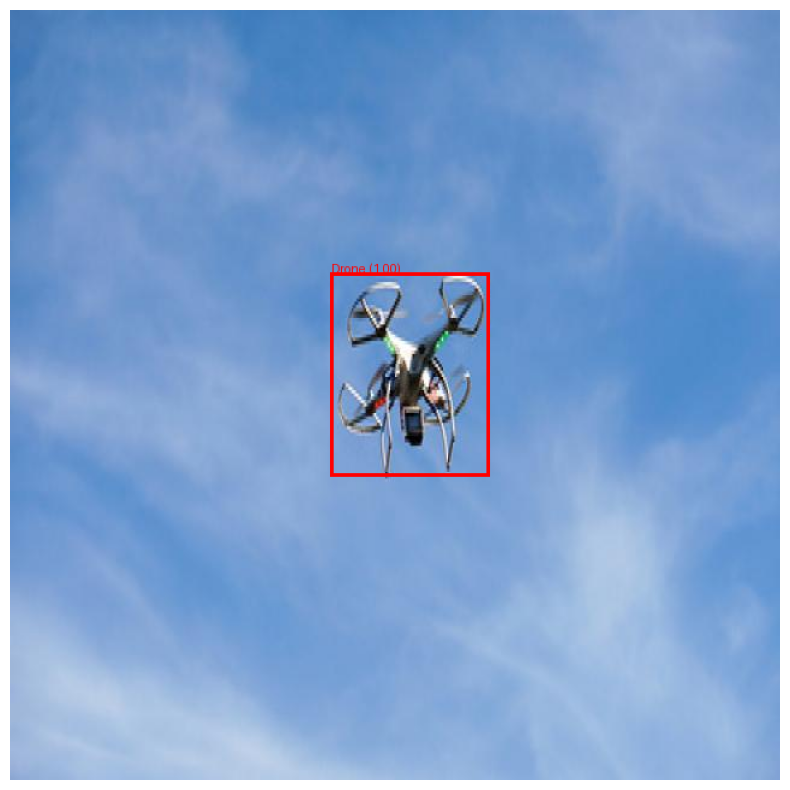

 35%|███▍      | 57/165 [00:05<00:09, 10.99it/s]

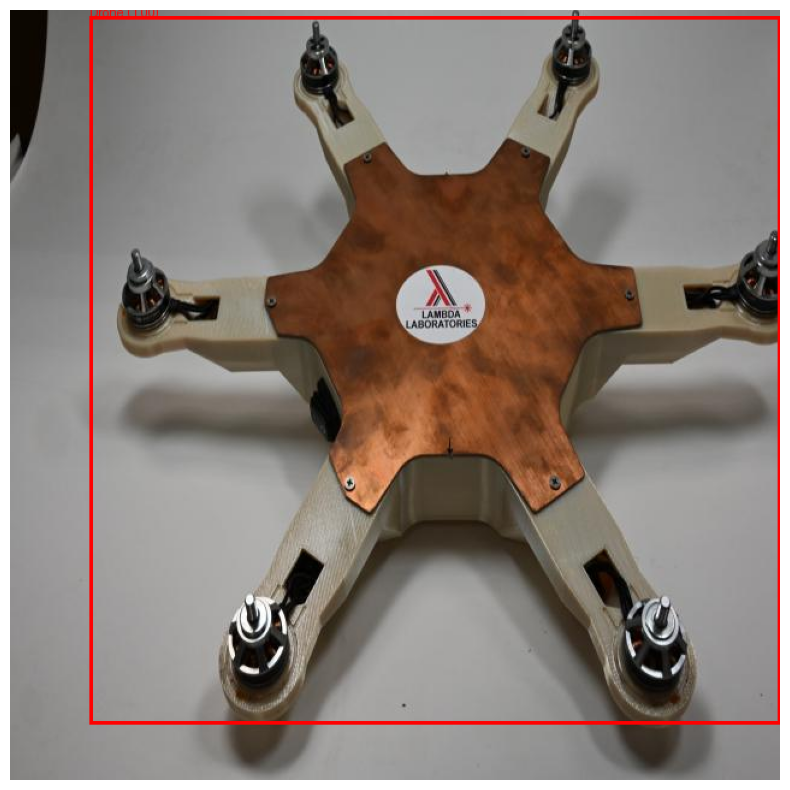

 36%|███▌      | 59/165 [00:06<00:13,  7.74it/s]

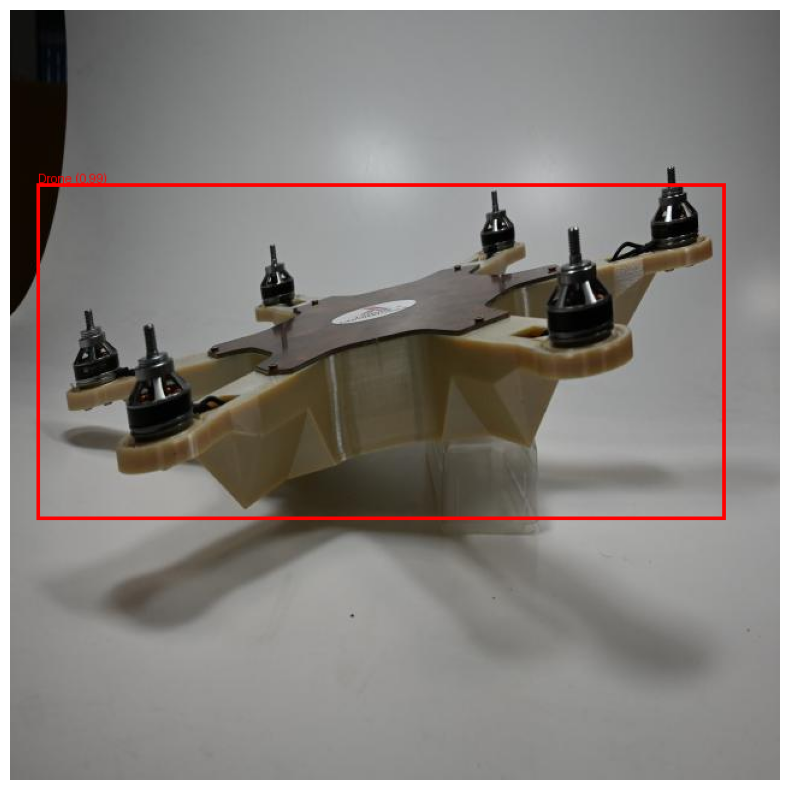

 73%|███████▎  | 120/165 [00:11<00:04, 10.39it/s]

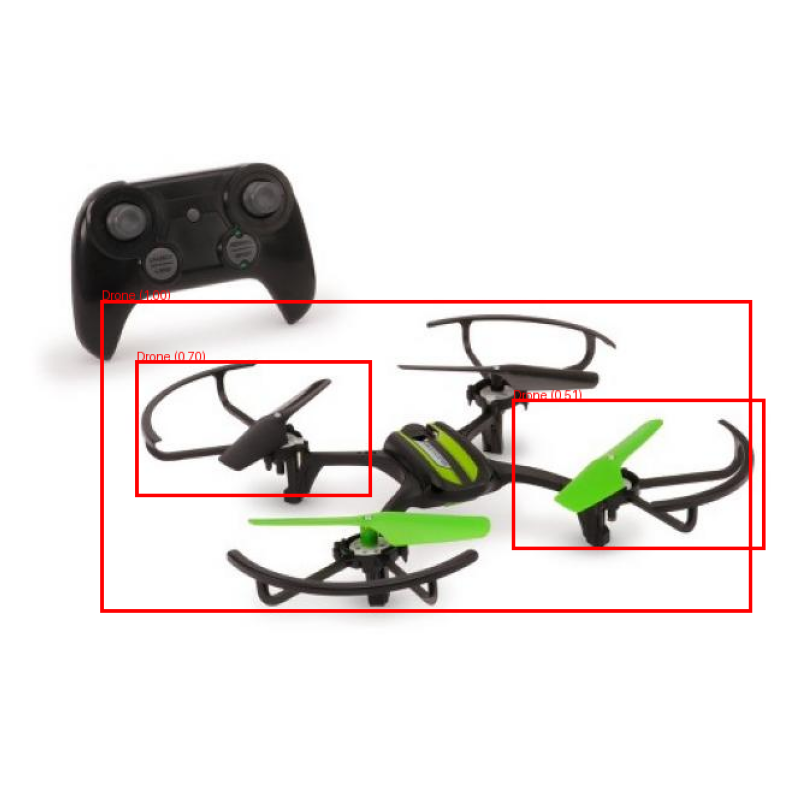

 82%|████████▏ | 136/165 [00:13<00:02, 10.61it/s]

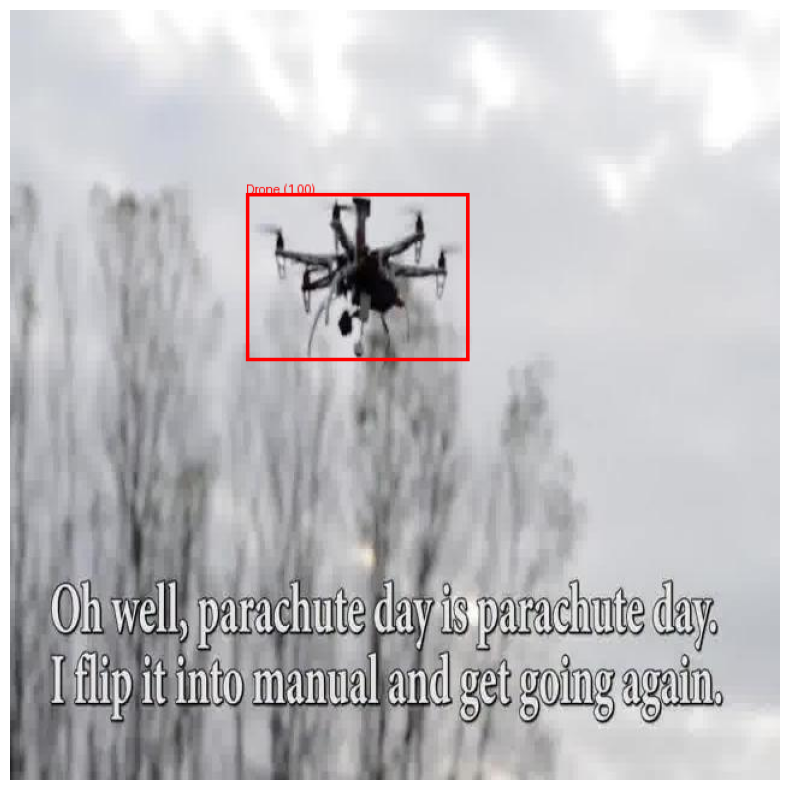

100%|██████████| 165/165 [00:16<00:00, 10.00it/s]

✅ predictions2.json oluşturuldu: predictions.json


In [ ]:
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random

model.eval()
results = []
img_paths = sorted(glob.glob("/content/drive/MyDrive/test/images/*.jpg"))

for img_id, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    # Görseli yükle
    image = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(image).to(device).unsqueeze(0)

    with torch.no_grad():
        preds = model(tensor)[0]

    # Görselleştirme için
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    for i in range(len(preds["boxes"])):
        box = preds["boxes"][i].cpu().numpy().tolist()
        score = preds["scores"][i].item()
        category_id = int(preds["labels"][i].item())

        # Sadece %50 üzeri güven skoru olanları kaydet
        if score >= 0.5:
            x, y, x2, y2 = box
            w, h = x2 - x, y2 - y

            # Sonuçları kaydet
            results.append({
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],
                "score": score
            })

            # Tahminleri görselleştir
            draw.rectangle([x, y, x2, y2], outline="red", width=3)
            draw.text((x, y - 10), f"Drone ({score:.2f})", fill="red", font=font)

    # Ekrana bastır (Her seferinde rastgele 5 görsel seçmek için)
    if random.random() < 0.05:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        plt.show()

# Tahminleri JSON dosyasına kaydet
with open("predictions2.json", "w") as f:
    json.dump(results, f)

print("✅ predictions2.json oluşturuldu: predictions.json")


  0%|          | 0/165 [00:00<?, ?it/s]

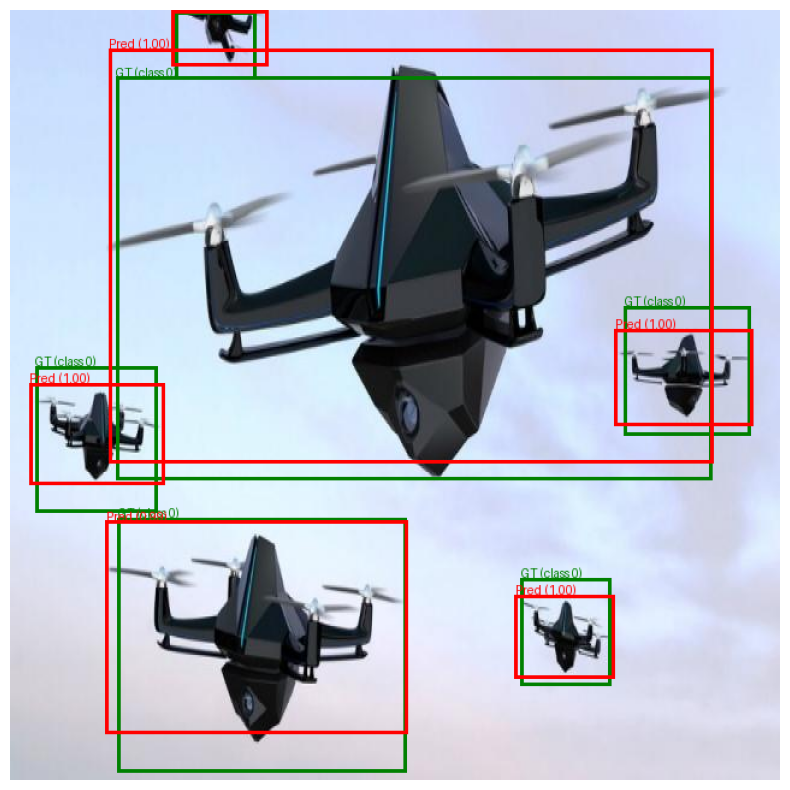

 10%|█         | 17/165 [00:02<00:18,  8.04it/s]

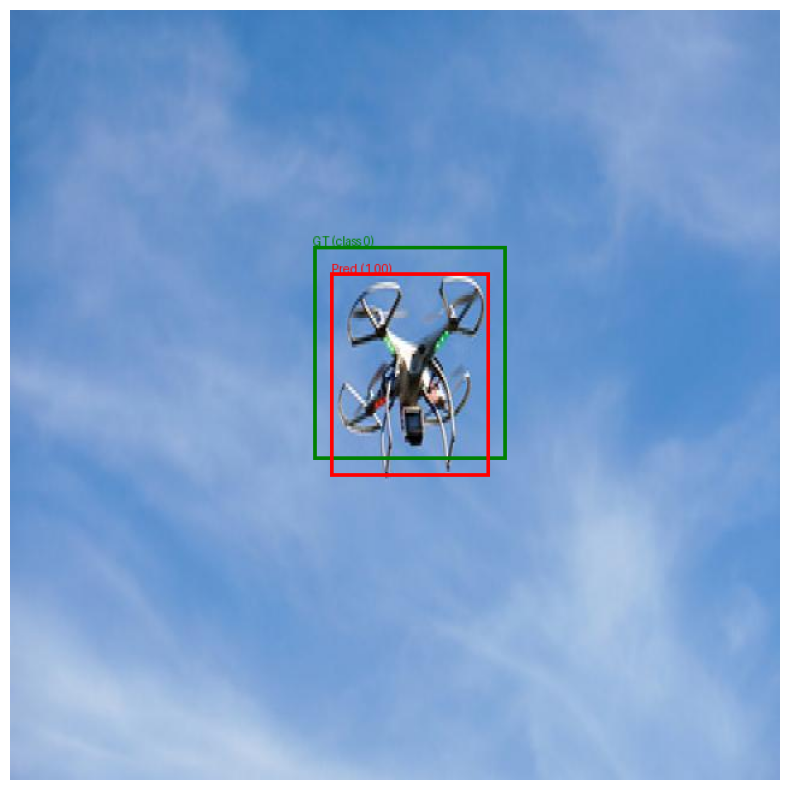

 12%|█▏        | 19/165 [00:03<00:51,  2.86it/s]

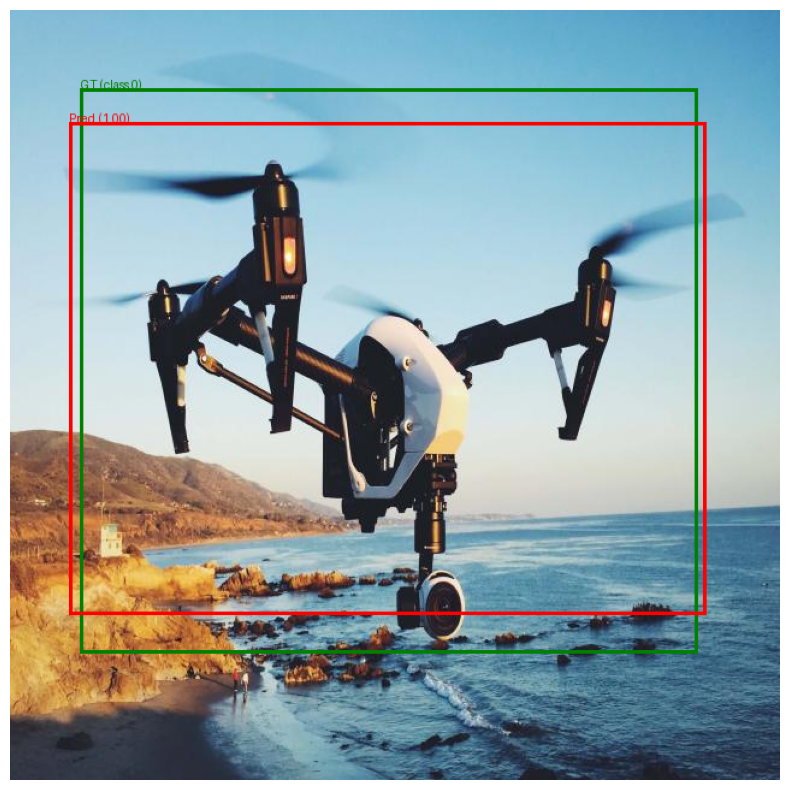

 18%|█▊        | 30/165 [00:05<00:17,  7.82it/s]

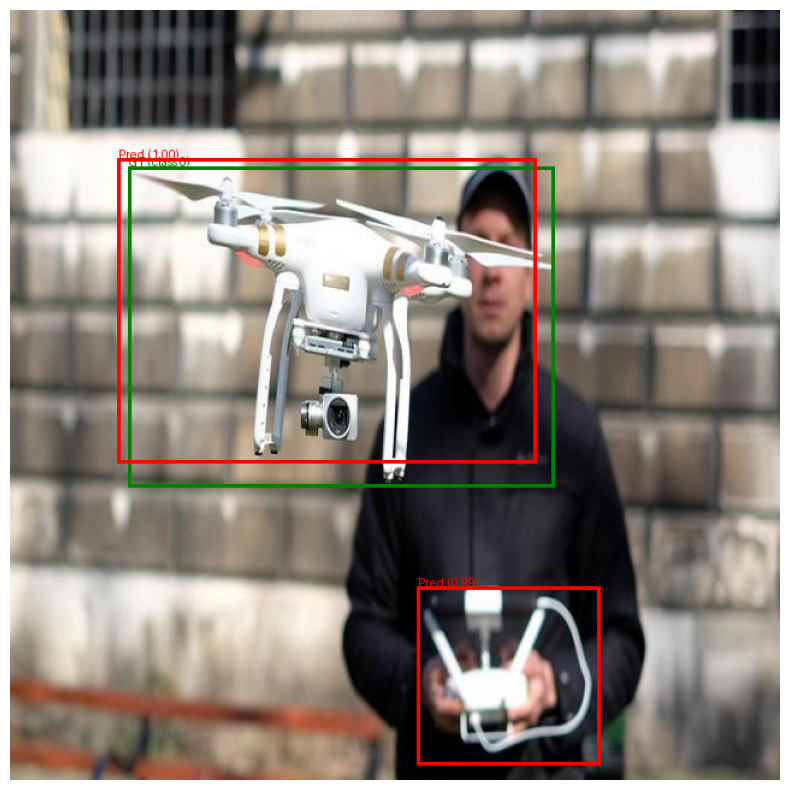

 19%|█▉        | 32/165 [00:05<00:26,  4.96it/s]

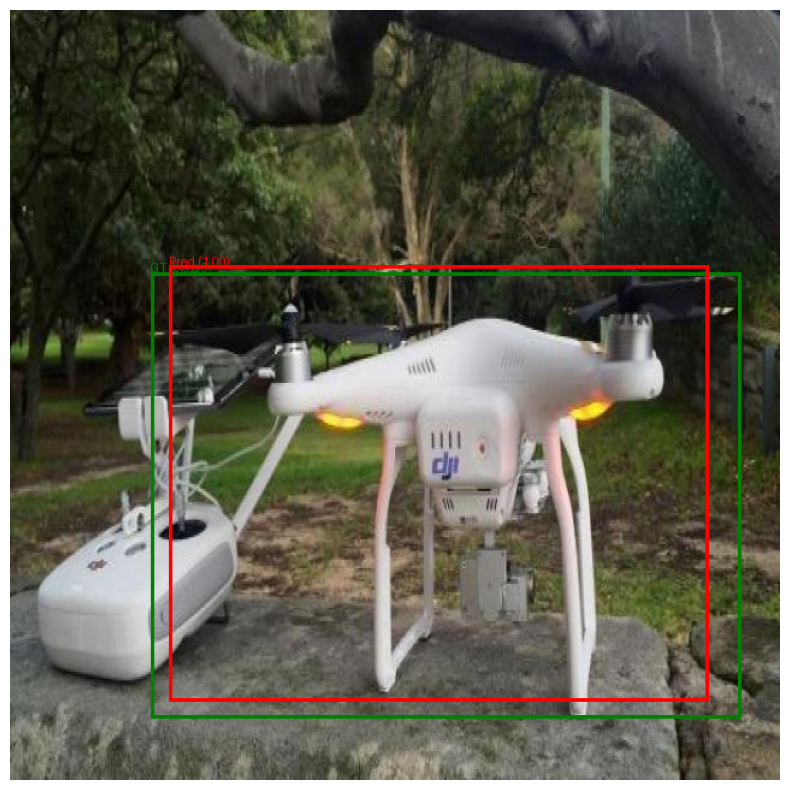

 20%|██        | 33/165 [00:06<00:35,  3.70it/s]

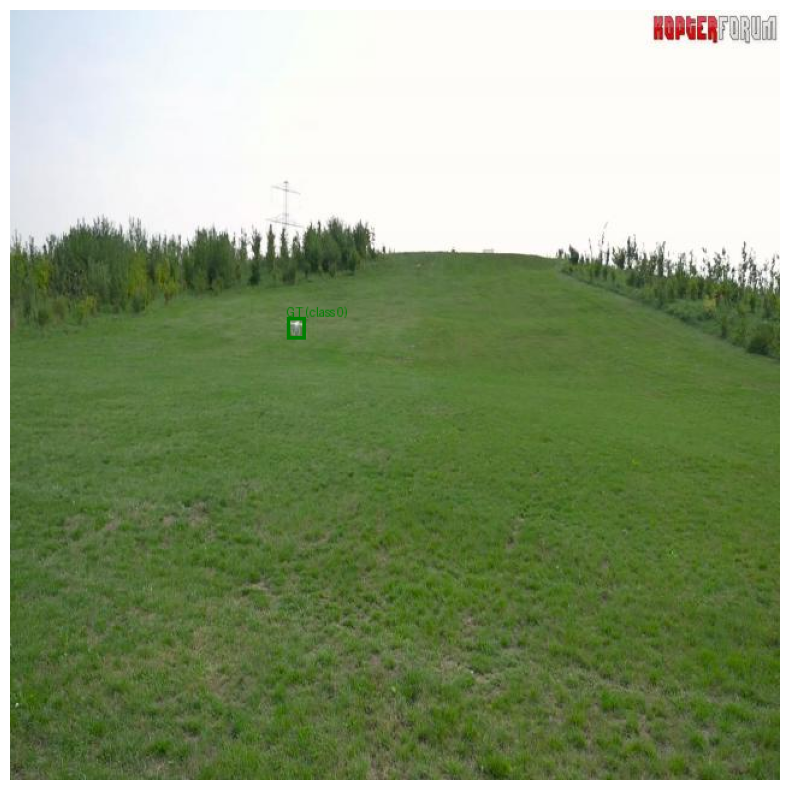

 21%|██        | 34/165 [00:06<00:41,  3.13it/s]

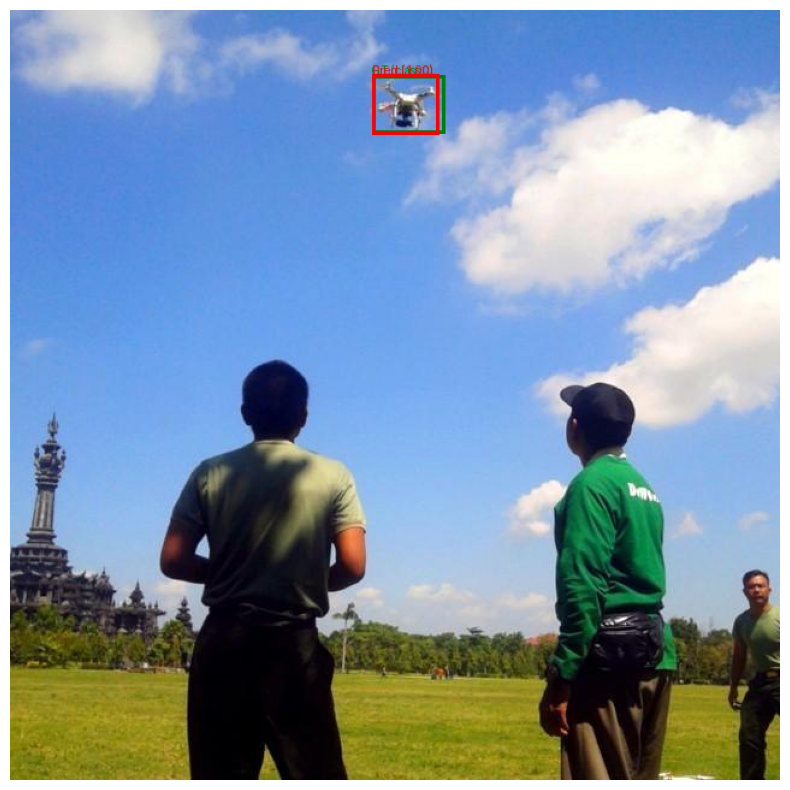

 22%|██▏       | 36/165 [00:07<00:40,  3.22it/s]

In [ ]:
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import random
import os

# Font seçimi
try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf", 20)
except IOError:
    font = ImageFont.load_default()

model.eval()
results = []
img_paths = sorted(glob.glob("/content/drive/MyDrive/test/images/*.jpg"))

for img_id, img_path in tqdm(enumerate(img_paths), total=len(img_paths)):
    # Görseli yükle
    image = Image.open(img_path).convert("RGB")
    tensor = F.to_tensor(image).to(device).unsqueeze(0)
    draw = ImageDraw.Draw(image)

    # Tahminleri al
    with torch.no_grad():
        preds = model(tensor)[0]

    # Gerçek etiketleri çiz
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    if os.path.exists(label_path):
        with open(label_path) as f:
            for line in f.readlines():
                cls, cx, cy, w, h = map(float, line.strip().split())
                width, height = image.size
                x1 = (cx - w / 2) * width
                y1 = (cy - h / 2) * height
                x2 = (cx + w / 2) * width
                y2 = (cy + h / 2) * height

                # Gerçek kutuyu yeşil renkte çiz
                draw.rectangle([x1, y1, x2, y2], outline="green", width=3)
                draw.text((x1, y1 - 10), f"GT (class {int(cls)})", fill="green", font=font)

    # Tahmin edilen kutuları çiz
    for i in range(len(preds["boxes"])):
        box = preds["boxes"][i].cpu().numpy().tolist()
        score = preds["scores"][i].item()
        category_id = int(preds["labels"][i].item())

        # Sadece %50 üzeri güven skoru olanları kaydet
        if score >= 0.5:
            x, y, x2, y2 = box
            w, h = x2 - x, y2 - y

            # Sonuçları kaydet
            results.append({
                "image_id": img_id,
                "category_id": category_id,
                "bbox": [x, y, w, h],
                "score": score
            })

            # Tahmin edilen kutuyu kırmızı renkte çiz
            draw.rectangle([x, y, x2, y2], outline="red", width=3)
            draw.text((x, y - 10), f"Pred ({score:.2f})", fill="red", font=font)

    # Görselleri rastgele seçmek için
    if random.random() < 0.2:
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis("off")
        plt.show()

# Tahminleri JSON dosyasına kaydet
with open("predictions.json", "w") as f:
    json.dump(results, f)

print("✅ predictions.json oluşturuldu: predictions.json")


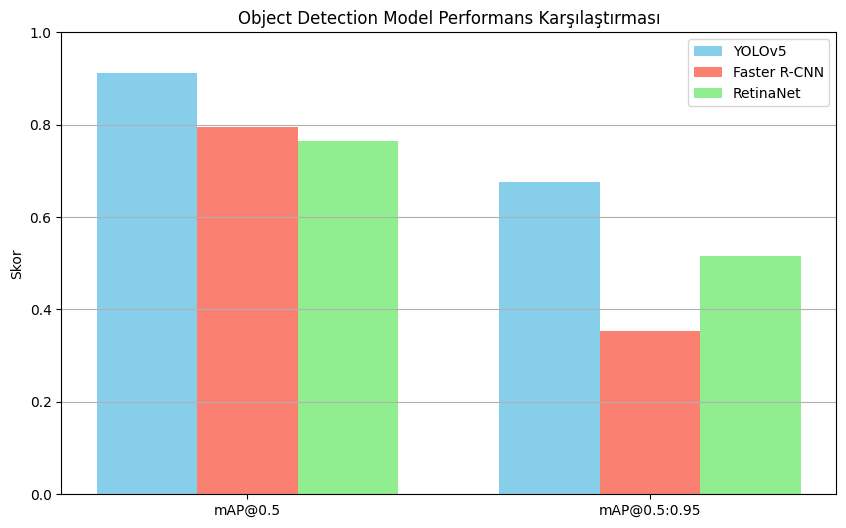

In [ ]:
import matplotlib.pyplot as plt

labels = ["mAP@0.5", "mAP@0.5:0.95"]
yolo_scores = [0.912, 0.677]
faster_scores = [0.796, 0.354]
retina_scores = [0.764, 0.515]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar([i - 0.25 for i in x], yolo_scores, width=0.25, label="YOLOv5", color='skyblue')
plt.bar([i for i in x], faster_scores, width=0.25, label="Faster R-CNN", color='salmon')
plt.bar([i + 0.25 for i in x], retina_scores, width=0.25, label="RetinaNet", color='lightgreen')

plt.xticks(x, labels)
plt.ylabel("Skor")
plt.title("Object Detection Model Performans Karşılaştırması")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.show()
